# Contrastive analysis
Yeah

In [28]:
import os
import sys

if colab := 'google_colab' in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    # in case we'll do a shared drive, this will have to be changed.
    # For now it is basically a placeholder
    BASE_PATH = "drive/MyDrive/HLT/ProjectAthena/"
    sys.path.insert(0,BASE_PATH)

    !pip install wordcloud
    !pip install -U scikit-learn
    !pip install -U nltk
    !pip install -U seaborn
else:
    BASE_PATH = ".."

In [29]:
# More imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from typing import List, Dict, Optional, Tuple

In [30]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/andrea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/andrea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
# Using NLTK stopwords
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

## Creating our dataset distribution

In [32]:
df = pd.read_csv(os.path.join(BASE_PATH,'philosophy_data.csv'))
df.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


In [33]:
SCHOOLS = df['school'].unique()

In [34]:
# all this mess because .csv saves lists as strings
df['tokenized_txt'] = df['tokenized_txt'].apply(lambda frase: [word.strip('\'') for word in frase[1:-1].split(', ')])

### ~~Space~~ Tokens oddity

We want to create our bag of words, to create the distributions. But, while working, I noticed something odd...

**Way 1**: We already created bag of words! We did so by using Scikit-learn's `CountVectorizer` applied to the `sentence_str` column of the dataframe. We could use that here as well...

In [8]:
from exploration_utils import create_bow

# create a dictionary with the BOW count for each philosophical school,
# in which the stopwords are filtered out
schools_bow_sklearn = {}
for school in SCHOOLS:
    schools_bow_sklearn[school] = create_bow(school=school, dataframe=df, stopwords=stopwords_list)

**Way 2**: We could stick to NLTK and use the `FreqDist` on the already tokenized sentences of the dataframe (`tokenized_txt` column)

In [35]:
# Let's create a BoW for each class, using NLTK and the tokenized_txt column
from itertools import chain

COMPARE = 0

schools_bow = {}
schools_bow_Mk2 = {}
for school in SCHOOLS:
    tokenized_sentences = df.loc[df['school']==school,'tokenized_txt'] 
    schools_bow[school] = nltk.FreqDist([w for w in chain.from_iterable(tokenized_sentences) if w not in stopwords_list])
    
    if COMPARE:
        tokenized_sentences_Mk2 = [nltk.word_tokenize(sent.lower()) for sent in df.loc[df['school']==school,'sentence_str']]
        schools_bow_Mk2[school] = nltk.FreqDist([w for w in chain.from_iterable(tokenized_sentences_Mk2) if w not in stopwords_list])

Are the two methods equal?

In [10]:
nltk_minus_sklearn = {}
sklearn_minus_nltk = {}
for school in SCHOOLS:
    from_nltk = dict(schools_bow[school])
    from_sklearn = schools_bow_sklearn[school]
    print(f'School: {school}, equal: {from_nltk == from_sklearn}')

    print(f"FreqDist's n° elements: {len(from_nltk)}")
    print(f"Length BoW from sklearn's CountVectorizer: {len(from_sklearn)}")

    nltk_minus_sklearn[school] = {k:from_nltk[k] for k in from_nltk.keys() - from_sklearn.keys()}
    sklearn_minus_nltk[school] = {k:from_sklearn[k] for k in from_sklearn.keys() - from_nltk.keys()}
    print(f'In NLTK but not sklearn: {nltk_minus_sklearn[school]}')
    print(f'In sklearn but not NLTK: {sklearn_minus_nltk[school]}')
    print()

School: plato, equal: False
FreqDist's n° elements: 18473
Length BoW from sklearn's CountVectorizer: 18484
In NLTK but not sklearn: {'dikaıon': 1, 'poleos': 1, 'nomesis': 1, 'philanthropia': 1, 'kuon': 1, 'ethonoe': 1, 'oionistic': 2, 'horosa': 1, 'hecaerge': 1, 'mosthai': 1, 'phronesis': 6, 'planeta': 1, 'dioxis': 1, 'aer': 3, 'hudor': 3, 'gnome': 2, 'doxes': 1, 'thelus': 1, 'boulesis': 1, 'entree': 1, 'enantiotes': 1, 'oiesis': 1, 'pteros': 1, 'taxeos': 2, 'zen': 3, 'mneme': 1, 'proteges': 1, 'meden': 1, 'skleroter': 1, 'chremata': 2, 'hektor': 1, 'parakatatheke': 1, 'daemones': 2, 'anthropos': 3, 'enkrates': 1, 'diaıon': 3, 'sophron': 3, 'aner': 1, 'eros': 7, 'nouthetesis': 1, 'oikeiotes': 1, 'sema': 2, 'houtos': 1, 'neuron': 1, 'heone': 1, 'aeitheer': 1, 'sozetai': 1, 'sophronein': 1, 'naıvete': 2, 'chrestotes': 1, 'eleutheriotes': 1, 'ethelemos': 1, 'ateros': 1, 'hesuchei': 1, 'kakophuıa': 1, 'sophistes': 2, 'phones': 1, 'gignoskomenen': 1, 'demegoros': 1, 'hepeısteme': 2, 'seion'

School: german_idealism, equal: False
FreqDist's n° elements: 27975
Length BoW from sklearn's CountVectorizer: 27992
In NLTK but not sklearn: {'': 1, 'jons': 1, 'wohler': 2, 'algebrique': 1, 'gleichgultiges': 1, 'asthetik': 1, 'differentiel': 1, 'degres': 1, 'ursprunglichkeit': 1, 'satze': 1, 'verstandiges': 1, 'bohme': 1, 'numeriques': 2, 'algebriques': 1, 'vollstandiger': 1, 'adaquate': 1, 'reflexions': 4, 'phadon': 1, 'identitat': 1, 'samtliche': 1, 'preestablie': 1, 'jubilaumsausgabe': 1, 'ecrire': 1, 'metaphysique': 3, 'developpons': 1, 'gesprachen': 1, 'wurzburg': 1, 'ausgefuhrte': 1, 'gesprach': 1, 'jahrbucher': 1, 'reduits': 1, 'zoller': 1, 'degages': 1, 'punctualitat': 1, 'superieure': 1, 'beytrage': 1, 'lowe': 1, 'ecole': 3, 'naıve': 3, 'zufalligkeit': 1, 'ursprungliche': 1, 'quantitativitat': 2, 'gobbard': 1, 'quantites': 1, 'nurnberg': 2, 'meme': 1, 'gunter': 1, 'objectivitat': 2, 'evanouissans': 1}
In sklearn but not NLTK: {'rentiel': 1, 'zufa': 1, 'ngliche': 1, 'versta': 

No, they're not. 

I'm pretty sure that part of the reason is because the `create_bow` function uses the column `sentence_str`, so it's `sklearn.CountVectorizer` that does the tokenization. I've checked internally and there are weird characters in some sentences (especially from Plato and Aristotle. Letters with weird accents, that is). Whereas, when building the BoW with `nltk.FreqDist()` method we use already tokenized text, since it uses the `tokenized_txt` column. 

In brief, the tokenizer used to get the `tokenized_txt` column and that of `sklearn.CountVectorizer()` work differently.

Anyway, I'm going with the NLTK way. I may change the `create_bow` function sooner or later.

In [11]:
def dataframe_prober(word:str,
                     school:str):
    subwindow = df.loc[df['school']==school, ['tokenized_txt', 'sentence_str']]
    for i,sentence in zip(subwindow.index,subwindow['tokenized_txt']):
        if word in sentence:
            return(i, subwindow.loc[i,'sentence_str'])

In [12]:
index, sentence = dataframe_prober('wurzburg','german_idealism')
print(f'At index {index}: {sentence}')

At index 267307: To display (Bamberg and Würzburg: at Göbbard's,.


In [13]:
tot_count = 0
for school in SCHOOLS:
    school_count = len(sklearn_minus_nltk[school])+len(nltk_minus_sklearn[school])
    print(f'For the class {school}, total number of "oddities" is {school_count}')
    tot_count += school_count

print(f'Yielding a total of {tot_count} mismatches across all schools')

For the class plato, total number of "oddities" is 439
For the class aristotle, total number of "oddities" is 21
For the class empiricism, total number of "oddities" is 0
For the class rationalism, total number of "oddities" is 0
For the class analytic, total number of "oddities" is 47
For the class continental, total number of "oddities" is 0
For the class phenomenology, total number of "oddities" is 0
For the class german_idealism, total number of "oddities" is 115
For the class communism, total number of "oddities" is 0
For the class capitalism, total number of "oddities" is 0
For the class stoicism, total number of "oddities" is 0
For the class nietzsche, total number of "oddities" is 2
For the class feminism, total number of "oddities" is 0
Yielding a total of 624 mismatches across all schools


So the total number has a really little impact. The words affected by this problem are not many. But it's one thing to consider when building a model.

### Back to business

In [36]:
# Normalize the BoW count to get the distribution of each class
schools_distribution = {}
for school in SCHOOLS:
    schools_distribution[school] = {key:val/schools_bow[school].N() for (key,val) in schools_bow[school].items()}

Let's also get the word distribution for the whole dataset.

The `schools_distribution`s use the original tokens, but for the overall bag of word we put all letters in lowercase 

In [37]:
# Lowercase the words and remove stopwords (we're just comparing counts)
overall_bow = nltk.FreqDist([w.lower() for w in chain.from_iterable(df['tokenized_txt']) if (w not in stopwords_list and w.isalnum())])

threshold = 0   # 0.01
total_words = sum(overall_bow.values())  # overall_bow.N()
lower_bound = threshold*total_words

# filter away infrequent words
thresholded_distribution = nltk.FreqDist({key:val for (key,val) in overall_bow.items() if val>threshold})

# normalize
total_mass = sum(thresholded_distribution.values()) # thresholded_distribution.N()
philosophy_distribution = {k:v/total_mass for (k,v) in thresholded_distribution.items()}

assert sum(philosophy_distribution.values()) == 1, "There's a problem in the normalization: sum is not one"

In [38]:
overall_bow.most_common(20)

[('one', 48216),
 ('would', 24171),
 ('must', 21140),
 ('things', 17482),
 ('also', 16781),
 ('may', 16298),
 ('man', 16152),
 ('time', 15307),
 ('us', 15100),
 ('even', 14461),
 ('first', 13880),
 ('say', 12856),
 ('way', 12854),
 ('nature', 12796),
 ('two', 12474),
 ('world', 12088),
 ('therefore', 11722),
 ('reason', 11464),
 ('without', 11432),
 ('thing', 11275)]

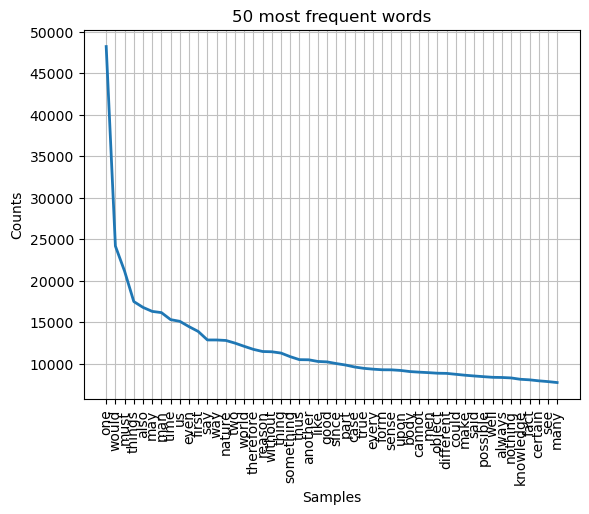

<Axes: title={'center': '50 most frequent words'}, xlabel='Samples', ylabel='Counts'>

In [39]:
overall_bow.plot(50,title='50 most frequent words')

## Distributions comparison

Our contrastive analysis is with three corpora:
- NLTK Gutenberg corpus. This comparison is interesting because this corpus should be "similar" to our reference philosophy corpus, since the former is composed of books 
- NLTK Brown corpus. This corpus is peculiar because is divided into genres (or categories), so is quite useful for studying sistematic similaritied between our corpus and different genres.
- SimpleEnglish corpus. This comparison allows us to measure how distant our corpus is from one that use a simple language, albeit covering many topics. We could describe the SimpleEnglish corpus as being "broad and short", and the philosophy corpus as being "thin and tall". 

### Gutenberg corpus

In [14]:
# Caution! This saves things locally!
# Just needs to be executed once (or once in a while, to update)
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /home/andrea/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

Let's see which books are included in this corpus

In [40]:
from nltk.corpus import gutenberg
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

By comparing with the [list](http://philosophydata.com/bibliography.html) provided by the author of the Philosophy dataset, we can see that there are no books in common. This means that our analysis is fair, it's not spoiled by common texts between the corpora.

Upon inspection, the Gutenberg corpus is pretty clean. However, each file has those annoying headers. In the great scheme of things, they aren't very meaningful, but we can remove them pretty easily

In [41]:
filtered_words = []
threshold = 0  #0.05
for filename in gutenberg.fileids():
    words_list = gutenberg.words(filename)
    # We filter away stopwords and non-alphanumeric words
    # We also remove the trailing header
    filtered_words.append([w for w in words_list[words_list.index(']'):] if (w.lower() not in stopwords_list and w.isalnum())])

# We lowercase the words
gutenberg_freq_dist = nltk.FreqDist([w.lower() for w in chain.from_iterable(filtered_words)])

# We could remove the rarest words
total_mass = sum(gutenberg_freq_dist.values())  # gutenberg_freq_dist.N()
lower_bound = threshold*total_mass
gutenberg_distribution = {k:v/total_mass for (k,v) in gutenberg_freq_dist.items() if v>lower_bound}

assert sum(gutenberg_distribution.values()) == 1, "There's a problem in the normalization: sum is not one"

Let's now compare the distribution of our dataset with the one from the Gutenberg corpus.

The comparison I propose can be described as follows:
- The two distribution's supports will have some overlapping. That is, they'll share part of the vocabulary
- For both distributions, we compute the amount of shared mass. That is, how much mass lies on the shared support. This is a measure of "how much they have in common"
- We can see the distributions restricted to the common support as vectors, of course. So,
    - We compute the $l_2$ distance between the vectors (aka the two distributions on the shared support).
    - We compute the cosine of the angle (aka cosine similarity (cringe name btw)) between the two vectors

This should give a nice view at a glance of "how similar they are" in the part of the vocabulary which is in common.

In [42]:
# shared support: words present in both corpora
shared_support = [k for k in philosophy_distribution.keys() if k in gutenberg_distribution.keys()]

shared_mass_philosophy, shared_mass_gutenberg = 0,0 
distance, norm_philosophy, norm_gutenberg, dot = 0,0,0,0
for w in shared_support:
    phil, gut = philosophy_distribution[w], gutenberg_distribution[w]
    shared_mass_philosophy += phil
    shared_mass_gutenberg += gut

    # compute the angle
    dot += phil*gut
    norm_philosophy += phil**2
    norm_gutenberg += gut**2

    # distance between the sequences
    distance += (phil-gut)**2

norm_philosophy = np.sqrt(norm_philosophy)
norm_gutenberg = np.sqrt(norm_gutenberg)
distance = np.sqrt(distance)  

print(f'{100*shared_mass_philosophy:2.2f}% of the words in the philosophy corpus are shared with the gutenberg corpus')
print(f'{100*shared_mass_gutenberg:2.2f}% of the words in the Gutenberg corpus are shared with our philosophy corpus')
print(f'The distance of the two distributions (on the shared portion of the support) is {distance:.4e}')
print(f'The cosine similarity between the two distributions (on the shared portion of the support) is {dot/(norm_philosophy*norm_gutenberg):.4f}')

90.92% of the words in the philosophy corpus are shared with the gutenberg corpus
88.86% of the words in the Gutenberg corpus are shared with our philosophy corpus
The distance of the two distributions (on the shared portion of the support) is 2.8719e-02
The cosine similarity between the two distributions (on the shared portion of the support) is 0.5670


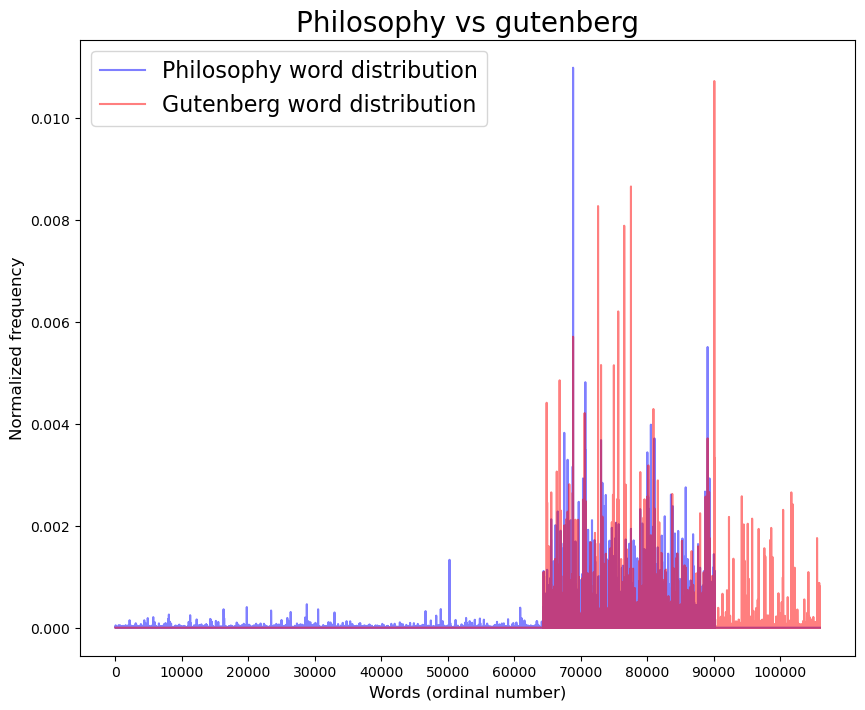

In [43]:
from exploration_utils import save_plot, plot_superimposed_distributions

RANGE = 100000

#fig, ax = plt.subplots(figsize=(10,12))
plot_superimposed_distributions(philosophy_distribution,
                                        gutenberg_distribution,
                                        label1='Philosophy word distribution',
                                        label2='Gutenberg word distribution',
                                        distribution1='philosophy',
                                        distribution2='gutenberg',)
                                        #range=RANGE)
#save_plot(plt, 'philosophy_vs_gutenberg_distributions')
plt.show()

### Word clouds

Who doesn't love those

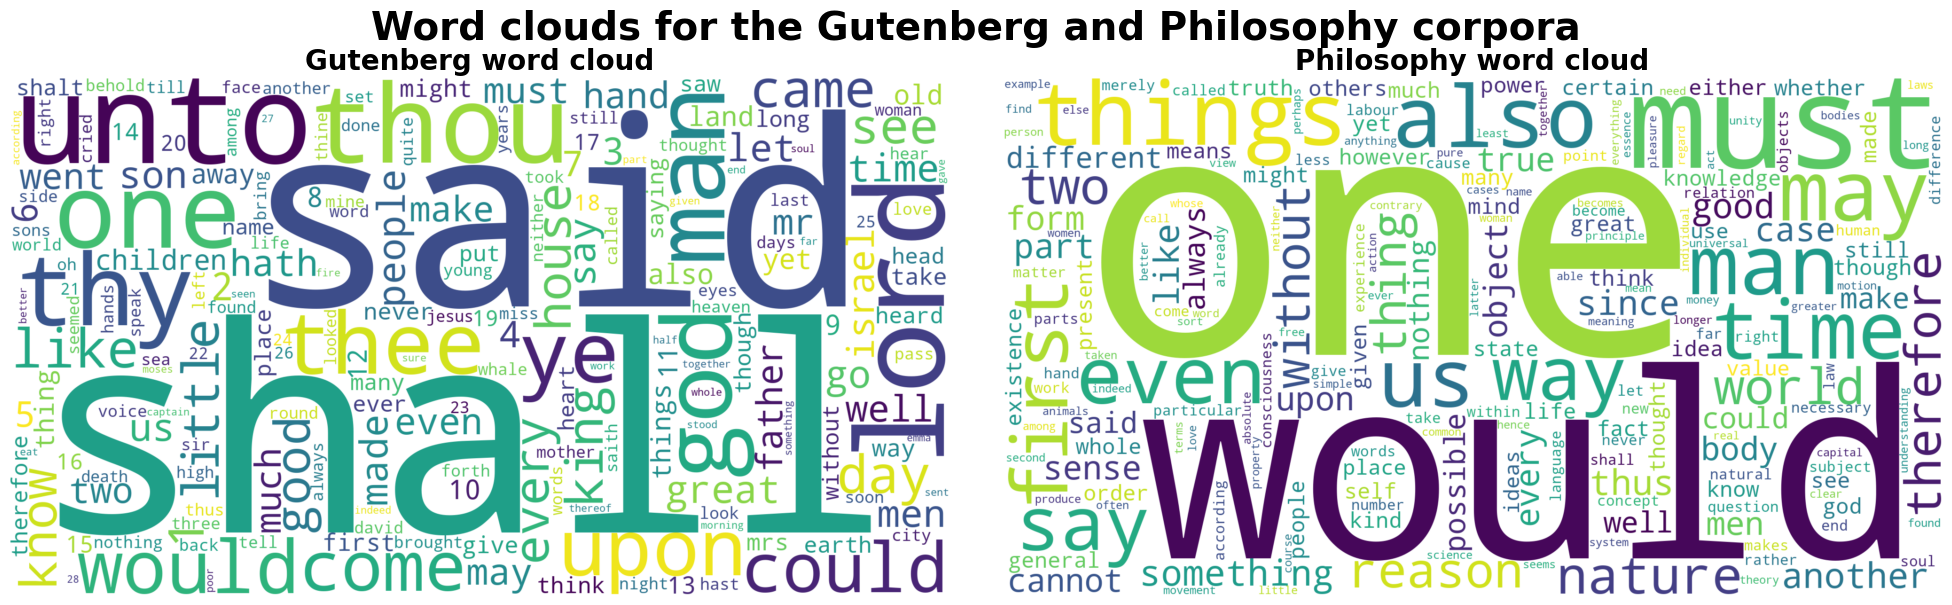

In [47]:
from exploration_utils import make_wordcloud

fig, ax = plt.subplots(1,2,figsize=(20,6))

wcGutenberg = make_wordcloud(gutenberg_distribution)    # thresholded and normalized
wcPhilosophy = make_wordcloud(philosophy_distribution)  # thresholded and normalized

ax[0].imshow(wcGutenberg, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Gutenberg word cloud', fontsize=20, fontweight='bold')

ax[1].imshow(wcPhilosophy, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Philosophy word cloud', fontsize=20, fontweight='bold')

plt.suptitle('Word clouds for the Gutenberg and Philosophy corpora', fontsize=28, fontweight='bold', y=1)

plt.tight_layout()
save_plot(plt, 'wordclouds_gutenberg_philosophy')
plt.show()

### Brown Corpus

In [25]:
# Caution! This saves things locally!
# Just needs to be executed once (or once in a while, to update)
nltk.download('brown')

[nltk_data] Downloading package brown to /home/andrea/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [26]:
from nltk.corpus import brown
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [27]:
print(f'The Brown corpus consists of {len(brown.words())} words')

The Brown corpus consists of 1161192 words


In [28]:
# word frequencies per category
brown_words_per_cat, brown_distribution = {}, {}
cat_checks = [True]

threshold = 0      #0.05
verbose = 1
for category in brown.categories():
    # We first filter away stopwords and non-alphanumeric words
    # (We don't want to compare the usage of stopwords in our dataset 
    # and in the Brown corpus. We already know they'll be sharing 
    # a lot of that mass...)
    filtered_words = [w for w in brown.words(categories=category) if (w.lower() not in stopwords_list and w.isalnum())]
    
    # I compare lowercase letters because we're just interested in counts/frequencies.
    # Maybe capitalizing some words may convey meaning, but it's something for
    # the classifiers, not this analysis.   
    freq_dist = nltk.FreqDist(w.lower() for w in filtered_words)
    
    # We may want to discard words that are too infrequent
    total_words = sum(freq_dist.values())    #freq_dist.N()
    lower_bound = threshold*total_words    
    brown_words_per_cat[category] = nltk.FreqDist({k:v for (k,v) in freq_dist.items() if v>lower_bound})

    # Normalize
    total_mass = brown_words_per_cat[category].N()  #sum(brown_words_per_cat.values())
    brown_distribution[category] = {key:val/total_mass for (key,val) in brown_words_per_cat[category].items()}

    if verbose: 
        checks = (len(filtered_words)==total_words, sum(brown_distribution[category].values())==1)
        if verbose > 1:
            print(f'category: {category}, n° words: {len(filtered_words)}')
            print(f'There are capitalized words: {any([w.lower()!=w for w in filtered_words])}')
            print(f'Total counts (in the freq_dist FreqDist object): {total_words}, matches n° of words (as it must be): {checks[0]}')
            print(f'Lower bound is {lower_bound}')
            print(f'Unitary mass in distribution: {checks[1]}')
            print()
        cat_checks.append(all(checks))

assert all(cat_checks)
print('All is well')


All is well


Let's now compare the distributions we have for our data with the ones we have for each category in the Brown corpus.

We use the same approach we used for the Gutenberg corpus.

In [23]:
shared_support, shared_mass_philosophy, shared_mass_brown = {},{},{}
dot, norm_philosophy, norm_brown, distance = {},{},{},{}

for category in brown.categories():
    shared_support[category] = [k for k in philosophy_distribution.keys() if k in brown_distribution[category].keys()]

    shared_mass_philosophy[category], shared_mass_brown[category], distance[category] = 0,0,0
    norm_brown[category], norm_philosophy[category], dot[category] = 0,0,0

    for w in shared_support[category]:
        phil, brwn = philosophy_distribution[w], brown_distribution[category][w]
        shared_mass_philosophy[category] += phil
        shared_mass_brown[category] += brwn

        # angle
        dot[category] += phil*brwn
        norm_philosophy[category] += phil**2
        norm_brown[category] += brwn**2      

        # distance
        distance[category] += (phil-brwn)**2

    norm_philosophy[category] = np.sqrt(norm_philosophy[category])
    norm_brown[category] = np.sqrt(norm_brown[category])
    distance[category] = np.sqrt(distance[category])

    print(f'Category {category} of the Brown corpus:')
    print(f'\t{100*shared_mass_philosophy[category]:2.2f}% of the words in the philosophy corpus are shared with the Brown corpus (for category {category})')
    print(f'\t{100*shared_mass_brown[category]:2.2f}% of the words in the Brown corpus are shared with our philosophy corpus (for category {category})')
    print(f'\tDistance: {distance[category]:.4e}')
    print(f'\tCosine similarity: {dot[category]/(norm_philosophy[category]*norm_brown[category]):.4f}')
    print()

Category adventure of the Brown corpus:
	62.57% of the words in the philosophy corpus are shared with the Brown corpus (for category adventure)
	92.43% of the words in the Brown corpus are shared with our philosophy corpus (for category adventure)
	Distance: 2.6281e-02
	Cosine similarity: 0.5886

Category belles_lettres of the Brown corpus:
	85.45% of the words in the philosophy corpus are shared with the Brown corpus (for category belles_lettres)
	94.72% of the words in the Brown corpus are shared with our philosophy corpus (for category belles_lettres)
	Distance: 1.6232e-02
	Cosine similarity: 0.8226

Category editorial of the Brown corpus:
	73.29% of the words in the philosophy corpus are shared with the Brown corpus (for category editorial)
	93.76% of the words in the Brown corpus are shared with our philosophy corpus (for category editorial)
	Distance: 2.0718e-02
	Cosine similarity: 0.6994

Category fiction of the Brown corpus:
	65.81% of the words in the philosophy corpus are sha

What if we want to plot this? Could we do it? How?? Fear not!! Our incredible `plot_superimposed_distributions` can easily handle this.

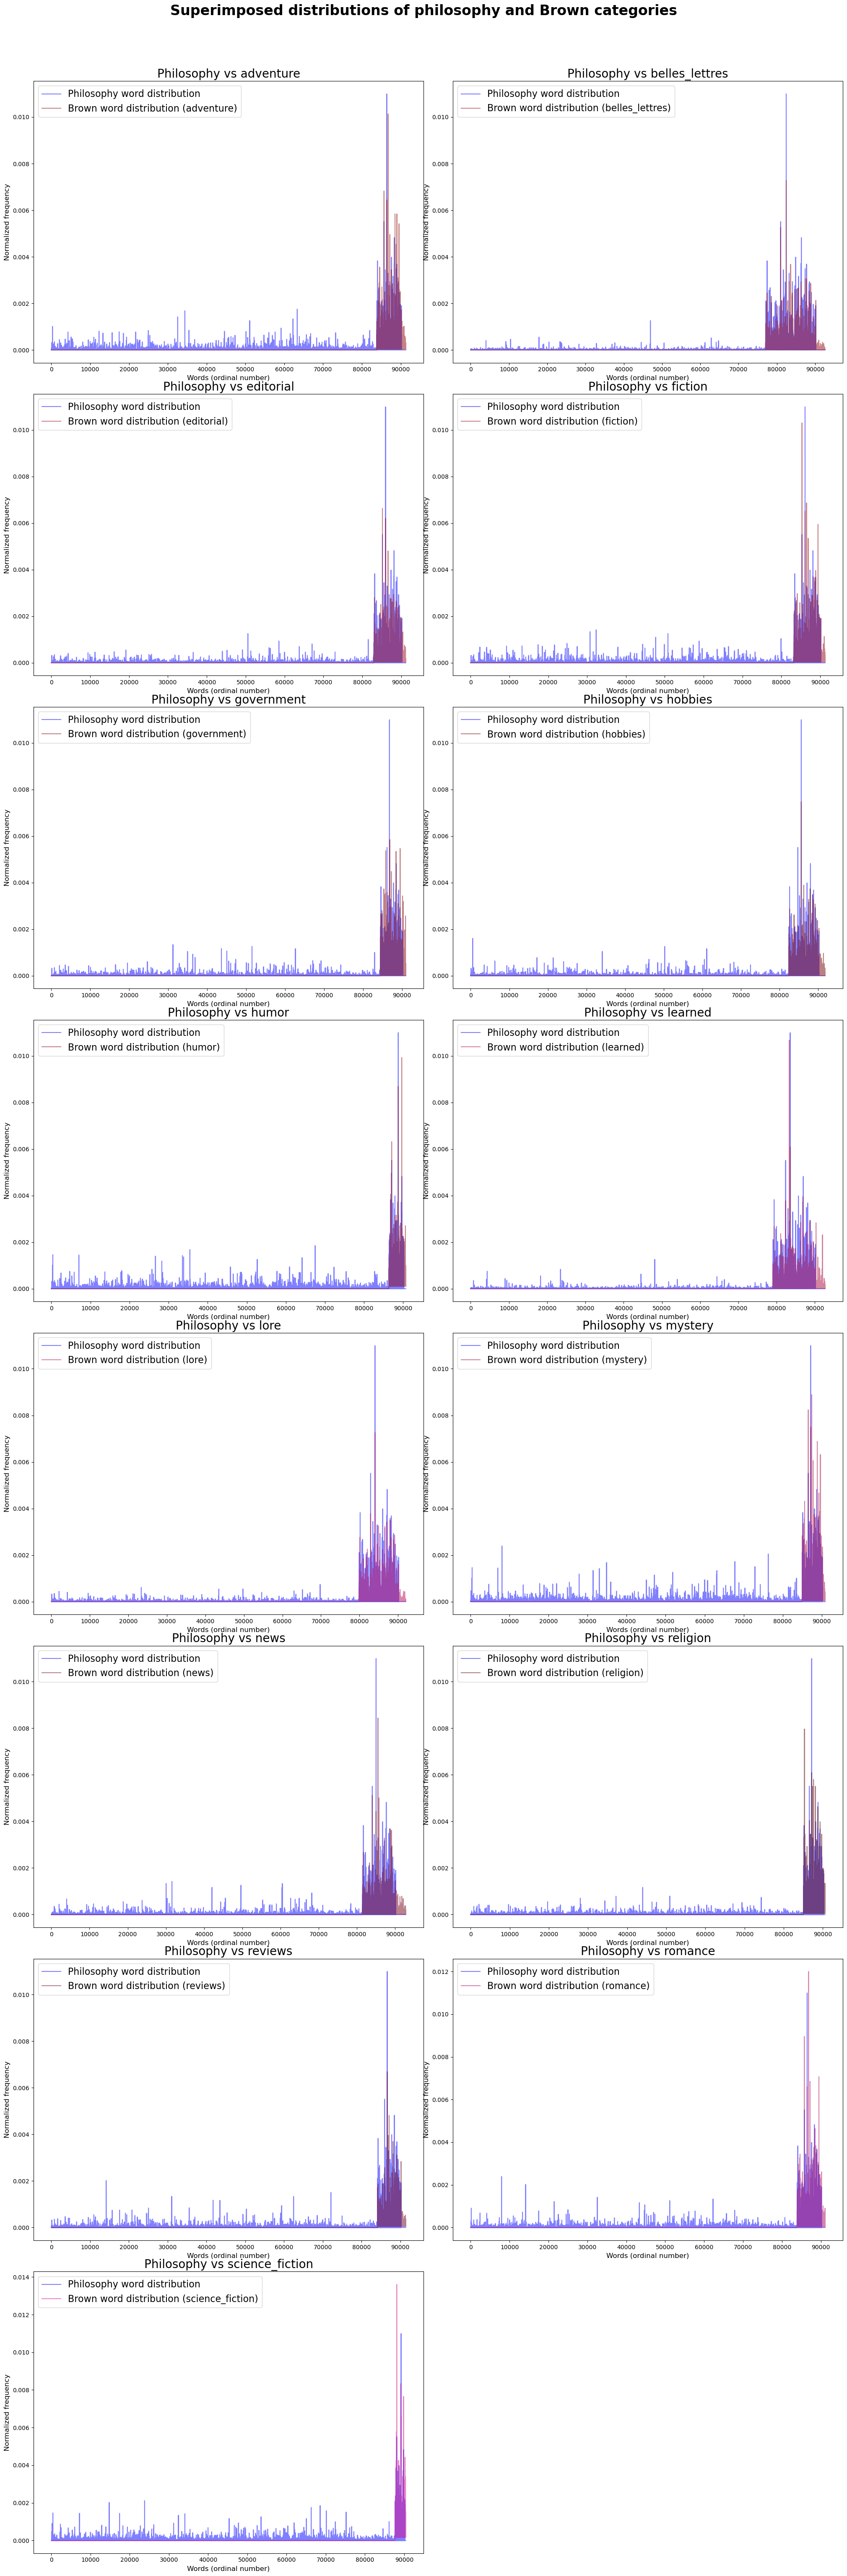

In [25]:
fig, axs = plt.subplots(8,2,figsize=(20,60))
axs = axs.ravel()

for i,category in enumerate(brown.categories()):
    plot_superimposed_distributions(philosophy_distribution, 
                                            brown_distribution[category],
                                            label1='Philosophy word distribution',
                                            label2=f'Brown word distribution ({category})',
                                            distribution1='philosophy',
                                            distribution2=f'{category}',
                                            color2=((145+5*i*np.sin(i))/255,(7+5*np.sin(i))/255,(7+5*i*(np.sin(i)+0.974))/255),
                                            ax=axs[i])

for i in range(len(brown.categories()),16):
    axs[i].axis('off')

plt.suptitle('Superimposed distributions of philosophy and Brown categories', fontsize=24, y=1.02, fontweight='bold')
plt.tight_layout(pad=0)
save_plot(plt, 'philosophy_vs_brown_distributions') 
plt.show()

### Simple english wikipedia corpus

The last corpus with which we compare our philosophy dataset is the [Plain text Wikipedia corpus](https://www.kaggle.com/datasets/ffatty/plain-text-wikipedia-simpleenglish).